# Getting Started with TensorRT

TensorRT is a SW library and an SDK for hardware-specific acceleration of Deep Learning models. In this hands-on tutorial, we will cover:
- Converting a pytorch model to TensorRT through onnx format
- Tools to interact with TensorRT models, notably Polygraphy
- Running inference with TensorRT models using Polygraphy CLI and Python API
- Benchmark inference speed performance of TensorRT models
- Validate result of TensorRT model inference vs Pytorch inference

In [1]:
!nvidia-smi

Mon Mar  4 13:15:14 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:09:00.0  On |                  Off |
| 33%   36C    P8    22W / 260W |    357MiB / 24576MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Prepare the example use-case

In this tutorial, we will use the **Breast Density Classification** model from the [MONAI Model Zoo](https://monai.io/model-zoo.html). This is an open-source Deep Learning model developed and release by Mayo Clinic.

Breast density is considered as an important risk factor for breast cancer in clinical practice. The breast density classification model takes a mammogram (an X-ray image of the breast) as input and output a 4-class classification score. The 4 classes correspond to
- class A - predominantly fat
- class B - scattered fibroglandular density
- class C - heterogeneously dense
- class D - extremely dense
where from A to D, the breast becomes denser. Below are sample images showing mammograms with breast density ranging from A to D in order.

<img src="sample_data/A/sample_A4.jpg" alt="A" width="15%"><img src="sample_data/B/sample_B2.jpg" alt="B" width="15%"><img src="sample_data/C/sample_C3.jpg" alt="C" width="15%"><img src="sample_data/D/sample_D2.jpg" alt="D" width="14%">

The breast density classification model was developed based on the InceptionV3 architecture

<img src="materials/inception.png" alt="inceptionv3" width="50%">

In this tutorial, we are going to optimize this model using TensorRT and benchmark its inference performance.

We first need to download the model and sample data from MONAI Model Zoo. This can be done using MONAI's `bundle.download` API by specifying model characteristics.

In [2]:
import os
import monai

MODEL_SOURCE = 'github'
MODEL_NAME = 'breast_density_classification'
MODEL_VERSION = '0.1.5'
BUNDLE_SAVE_DIR = './bundle'

OUTPUT_DIR = './output'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the breast density MONAI model bundle
#
monai.bundle.download(
    name=MODEL_NAME,
    version=MODEL_VERSION,
    source=MODEL_SOURCE,
    bundle_dir=BUNDLE_SAVE_DIR
  )

2024-03-04 13:15:33,906 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-03-04 13:15:33,909 - INFO - > name: 'breast_density_classification'
2024-03-04 13:15:33,911 - INFO - > version: '0.1.5'
2024-03-04 13:15:33,913 - INFO - > bundle_dir: './bundle'
2024-03-04 13:15:33,915 - INFO - > source: 'github'
2024-03-04 13:15:33,916 - INFO - > remove_prefix: 'monai_'
2024-03-04 13:15:33,918 - INFO - > progress: True
2024-03-04 13:15:33,919 - INFO - ---


2024-03-04 13:15:33,922 - INFO - Expected md5 is None, skip md5 check for file bundle/breast_density_classification_v0.1.5.zip.
2024-03-04 13:15:33,926 - INFO - File exists: bundle/breast_density_classification_v0.1.5.zip, skipped downloading.
2024-03-04 13:15:33,928 - INFO - Writing into directory: bundle.


Next, we create the model architecture, load the model weights from the downloaded bundle. This can be done by creating a model config object that contains all the information about the model: architecture, pre / post-processing, ...

In [3]:
import torch

DEVICE = 'cuda'

model_config_file = os.path.join(
    BUNDLE_SAVE_DIR, MODEL_NAME, 'configs', 'inference.json')
model_config = monai.bundle.ConfigParser()
model_config.read_config(model_config_file)
model_config['bundle_root'] = os.path.join(BUNDLE_SAVE_DIR, MODEL_NAME)

checkpoint = os.path.join(BUNDLE_SAVE_DIR, MODEL_NAME, 'models', 'model.pt')
model = model_config.get_parsed_content('network').to(DEVICE)
model.load_state_dict(torch.load(checkpoint, map_location=DEVICE))

model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104M/104M [00:03<00:00, 34.9MB/s]


TorchVisionFCModel(
  (features): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3

## 2. Pytorch model inference

We performance model inference using the original pytorch model without any extra optimization. Performance is benchmark on sample images provided in MONAI bundle.

First let's load all sample images into memory.

In [4]:
import os
import time
import numpy as np
import random


def load_data(as_array=False):
    """
    Load all sample images in memory, preprocessing applied. By default as list of torch tensors.
    If as_array == True, then load as list of numpy arrays.
    """
    top_dir = os.path.join(BUNDLE_SAVE_DIR, MODEL_NAME, 'sample_data')
    preprocessing = model_config.get_parsed_content('preprocessing')

    all_data = []
    
    for root, dirs, files in os.walk(top_dir):
        for curr_f in files:
            if curr_f.lower().endswith('.jpg'):
                sample_image = os.path.join(root, curr_f)
                input_data = preprocessing({'image': sample_image})
                input_data = torch.unsqueeze(input_data['image'], 0)
                
                if as_array:
                    all_data.append(input_data.array)
                else:
                    all_data.append(input_data.as_tensor())

    return all_data

all_data_tensors = load_data()


Then let's define a benchmark function for the torch model. This bencmark function takes an input torch model and a list of input images, then performs a certain number of inferences by randomly sampling from the input list of images. 

**Note: it is important to execute a certain number of warm up inference runs before benchmarking, to make the result representable and fair.**

In [5]:

def benchmark_torch(model, data_list, device='cuda', warmup=50, nruns=1000):
    """
    Benchmark a torch model inference by providing model and data list.
    """
    if warmup > 0:
        input_shape = data_list[0].shape
        input_dtype = data_list[0].dtype
        warmup_data = torch.randn(input_shape, dtype=input_dtype)
        warmup_data = warmup_data.to(device)
        
        print("warming up ...")
        with torch.no_grad():
            for _ in range(warmup):
                out = model(warmup_data)
    
        torch.cuda.synchronize()
    
    print("benchmarking ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            input_data = random.choice(data_list)
            input_data = input_data.to(device)

            start_time = time.time()
            out = model(input_data)
            torch.cuda.synchronize()
            
            end_time = time.time()
            
            timings.append(end_time - start_time)
            if i % 10 == 0:
                print('Iteration {}/{}, avg batch time {:.2f} ms'.format(
                    i, nruns, np.mean(timings)*1000))

    print()
    print("Input shape:", input_data.shape)
    print('Average throughput: {:.2f} images/second'.format(input_data.shape[0]/np.mean(timings)))
    
benchmark_torch(model, all_data_tensors)

warming up ...
benchmarking ...
Iteration 10/1000, avg batch time 34.94 ms
Iteration 20/1000, avg batch time 35.08 ms
Iteration 30/1000, avg batch time 35.10 ms
Iteration 40/1000, avg batch time 34.41 ms
Iteration 50/1000, avg batch time 33.88 ms
Iteration 60/1000, avg batch time 33.47 ms
Iteration 70/1000, avg batch time 33.20 ms
Iteration 80/1000, avg batch time 32.99 ms
Iteration 90/1000, avg batch time 32.99 ms
Iteration 100/1000, avg batch time 32.73 ms
Iteration 110/1000, avg batch time 32.45 ms
Iteration 120/1000, avg batch time 32.14 ms
Iteration 130/1000, avg batch time 31.92 ms
Iteration 140/1000, avg batch time 31.67 ms
Iteration 150/1000, avg batch time 31.44 ms
Iteration 160/1000, avg batch time 31.25 ms
Iteration 170/1000, avg batch time 31.04 ms
Iteration 180/1000, avg batch time 30.87 ms
Iteration 190/1000, avg batch time 30.78 ms
Iteration 200/1000, avg batch time 30.61 ms
Iteration 210/1000, avg batch time 30.44 ms
Iteration 220/1000, avg batch time 30.43 ms
Iteration

## 3. TensorRT optimization

Now let's optimize the model for inference using TensorRT. To get maximal performance enhancement from TensorRT, we will leverage the onnx format as an intermediate model format. The conversion steps are as follows
1. First convert the torch model to onnx model using `torch.onnx.export`
2. Then convert the onnx model to TensorRT engine. Multiple tools are available for this.


Let us use `torch.onnx.export` to export the torch model to onnx format.

In [6]:

ONNX_SAVE_PATH = os.path.join(OUTPUT_DIR, 'model.onnx')

torch.onnx.export(
    model.eval(),
    torch.rand(1, 3, 299, 299).to(DEVICE),
    ONNX_SAVE_PATH,
    verbose=False,
    opset_version=17
  )


Then we can use `polygraphy` to interact with the onnx model

For example, we can inspect the converted onnx model, get model information, for instance name of the input, shape of the input, output ...

In [7]:
!polygraphy inspect model output/model.onnx

[I] Loading model: /workspace/nv-inference-demo/notebooks/tensorrt/output/model.onnx
[I] ==== ONNX Model ====
    Name: main_graph | ONNX Opset: 17
    
    ---- 1 Graph Input(s) ----
    {x.1 [dtype=float32, shape=(1, 3, 299, 299)]}
    
    ---- 1 Graph Output(s) ----
    {915 [dtype=float32, shape=(1, 4)]}
    
    ---- 190 Initializer(s) ----
    
    ---- 241 Node(s) ----


For more examples with Plography CLIs, refer to its [documentation pages](https://github.com/NVIDIA/TensorRT/tree/main/tools/Polygraphy/examples/cli).

Most importantly, we can use polygraphy to convert the onnx model to different formats, including TensorRT engines. Within TensorRT, there can be multiple precision types for the model

<img src="materials/precision.png" alt="trt-precision" width="40%">

- Converting onnx model to TensorRT engine in FP32, no reduction in precision

In [8]:
!polygraphy convert output/model.onnx -o output/model.fp32.engine --builder-optimization-level 4

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I] Configuring with profiles:[
        Profile 0:
            {x.1 [min=[1, 3, 299, 299], opt=[1, 3, 299, 299], max=[1, 3, 299, 299]]}
    ]
[I] Building engine with configuration:
    Flags                  | []
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 24220.44 MiB, TACTIC_DRAM: 24220.44 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[I] Finished engine building in 105.067 seconds


- Converting onnx model to TF32 precision, to leverage built-in Tensor Cores in Ampere+ architecture GPUs

In [10]:
!polygraphy convert output/model.onnx -o output/model.tf32.engine --tf32 --builder-optimization-level 4

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I] Configuring with profiles:[
        Profile 0:
            {x.1 [min=[1, 3, 299, 299], opt=[1, 3, 299, 299], max=[1, 3, 299, 299]]}
    ]
[I] Building engine with configuration:
    Flags                  | [TF32]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 24220.44 MiB, TACTIC_DRAM: 24220.44 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[I] Finished engine building in 103.425 seconds


- Converting onnx model to FP16 precision, reducing to half precision data types

In [7]:
!polygraphy convert output/model.onnx -o output/model.fp16.engine --fp16 --builder-optimization-level 4

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I] Configuring with profiles:[
        Profile 0:
            {x.1 [min=[1, 3, 299, 299], opt=[1, 3, 299, 299], max=[1, 3, 299, 299]]}
    ]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 24220.44 MiB, TACTIC_DRAM: 24220.44 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitu

## 4. Performance benchmark

Polygraphy provides both CLIs and Python APIs which can be used to run inference with the converted TensorRT model.

Here I've wrote a `dataloader.py` file that is basically the same as the `load_data` method before. This script can be ingested by `polygraphy run` to feed 1000 iterations of data for performance benchmark. A warm-up run of 50 iterations will be performed before benchmarking with 1000 iterations, just as the pytorch benchmark function before.


Let's first benchmark the TensorRT FP32 model inference performance. **Note: the exact latency obtained will be different depending on the type of GPU you used.**

As you can see from the "average inference time" measurement below, we get already a decent amount of speed up, without even reducing the precision of the model. the speed up is due to multiple optimizations that tensorRT performs on the model & execution level: graph optimization, ops fusion, multiple streams ...

In [10]:
!polygraphy run output/model.fp32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py

[I] RUNNING | Command: /usr/local/bin/polygraphy run output/model.fp32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py
[I] trt-runner-N0-03/04/24-13:26:03     | Activating and starting inference
[I] Loading bytes from /workspace/notebooks/tensorrt/output/model.fp32.engine
[I] trt-runner-N0-03/04/24-13:26:03     | Running 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-13:26:03     | Finished 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-13:26:03    
    ---- Inference Input(s) ----
    {x.1 [dtype=float32, shape=(1, 3, 299, 299)]}
[I] trt-runner-N0-03/04/24-13:26:03    
    ---- Inference Output(s) ----
    {915 [dtype=float32, shape=(1, 4)]}
[I] trt-runner-N0-03/04/24-13:26:03     | Completed 1000 iteration(s) in 8156 ms | Average inference time: 8.156 ms.
[I] PASSED | Runtime: 29.727s | Command: /usr/local/bin/polygraphy run output/model.fp32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py


Let's now benchmark the TensorRT TF32 model inference performance. **Note: the exact latency obtained will be different depending on the type of GPU you used.**

On Ampere+ GPUs with Tensor Cores, you might see further speed-up for TF32 model compared to FP32 model. This is due to the selection of Tensor Core specific kernels by TensorRT optimizer. You might not get speed-up if Tensor Core ops in already enabled at global level.

In [9]:
!polygraphy run output/model.tf32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py

[I] RUNNING | Command: /usr/local/bin/polygraphy run output/model.tf32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py
[I] trt-runner-N0-03/04/24-13:25:26     | Activating and starting inference
[I] Loading bytes from /workspace/notebooks/tensorrt/output/model.tf32.engine
[I] trt-runner-N0-03/04/24-13:25:26     | Running 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-13:25:26     | Finished 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-13:25:26    
    ---- Inference Input(s) ----
    {x.1 [dtype=float32, shape=(1, 3, 299, 299)]}
[I] trt-runner-N0-03/04/24-13:25:26    
    ---- Inference Output(s) ----
    {915 [dtype=float32, shape=(1, 4)]}
[I] trt-runner-N0-03/04/24-13:25:26     | Completed 1000 iteration(s) in 8580 ms | Average inference time: 8.58 ms.
[I] PASSED | Runtime: 30.164s | Command: /usr/local/bin/polygraphy run output/model.tf32.engine --trt --warm-up 50 --data-loader-script ./dataloader.py


Finally, let's benchmark the TensorRT TF16 model inference performance. **Note: the exact latency obtained will be different depending on the type of GPU you used.**

You can observe the additional gain in performance from reducing the model from FP32 precision to FP16 (a.k.a half precision).

In [22]:
!polygraphy run output/model.fp16.engine --trt --warm-up 50 --data-loader-script ./dataloader.py

[I] RUNNING | Command: /usr/local/bin/polygraphy run output/model.fp16.engine --trt --warm-up 50 --data-loader-script ./dataloader.py
[I] trt-runner-N0-03/04/24-15:21:38     | Activating and starting inference
[I] Loading bytes from /workspace/notebooks/tensorrt/output/model.fp16.engine
[I] trt-runner-N0-03/04/24-15:21:38     | Running 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-15:21:38     | Finished 50 warm-up run(s)
[I] trt-runner-N0-03/04/24-15:21:38    
    ---- Inference Input(s) ----
    {x.1 [dtype=float32, shape=(1, 3, 299, 299)]}
[I] trt-runner-N0-03/04/24-15:21:38    
    ---- Inference Output(s) ----
    {915 [dtype=float32, shape=(1, 4)]}
[I] trt-runner-N0-03/04/24-15:21:38     | Completed 1000 iteration(s) in 7553 ms | Average inference time: 7.553 ms.
[I] PASSED | Runtime: 27.654s | Command: /usr/local/bin/polygraphy run output/model.fp16.engine --trt --warm-up 50 --data-loader-script ./dataloader.py


Polygraphy even allows to generate Python API script based on the CLI calls, which offers a great way to learn about Polygraphy APIs:

In [11]:
!polygraphy run output/model.fp16.engine --trt --warm-up 50 --data-loader-script ./dataloader.py --gen-script=output/benchmark_trt_fp16.py

[I] Writing script to: output/benchmark_trt_fp16.py


In [13]:
!cat output/benchmark_trt_fp16.py

#!/usr/bin/env python3
# Template auto-generated by polygraphy [v0.49.1] on 03/04/24 at 13:27:00
# Generation Command: /usr/local/bin/polygraphy run output/model.fp16.engine --trt --warm-up 50 --data-loader-script ./dataloader.py --gen-script=output/benchmark_trt_fp16.py
# This script runs /workspace/notebooks/tensorrt/output/model.fp16.engine using TensorRT.

from polygraphy.logger import G_LOGGER

from polygraphy import mod
from polygraphy.backend.common import BytesFromPath
from polygraphy.backend.trt import EngineFromBytes, TrtRunner
from polygraphy.comparator import Comparator
from polygraphy.exception import PolygraphyException

# Data Loader
data_loader = mod.import_from_script('./dataloader.py', name='load_data')

# Loaders
load_engine_bytes = BytesFromPath('/workspace/notebooks/tensorrt/output/model.fp16.engine')
deserialize_engine = EngineFromBytes(load_engine_bytes)

# Runners
runners = [
    TrtRunner(deserialize_engine),
]

# Runner Execution
results = Comparator.run(runne

For more details on Polygraphy APIs, refer to [its documentations here](https://github.com/NVIDIA/TensorRT/tree/release/8.6/tools/Polygraphy/examples/api).

## 5. Validation of results

The final step is to validate that after TensorRT optimization, the model still preserves its initial accuracy. **This is a very crucial step to perform, because if the optimized model does not preserve the initial Pytorch model performance, it cannot be used in production.**

This is case-by-case dependent, and is often by looking at either the element-wise error, or the overall performance metric, based on an independent validation dataset.

Here we compute the element-wise absolute and relative error between TensorRT FP16 model and Pytorch model final predictions. The models' final predictions are probability values, obtained from the raw model output logits by invoking the post-processing function registered in MONAI bundle.


In [18]:
import polygraphy.backend.trt as poly_trt
import polygraphy.backend.common as poly_common


postprocessing = model_config.get_parsed_content('postprocessing')

engine = poly_trt.engine_from_bytes(poly_common.bytes_from_path('./output/model.fp16.engine'))
trt_runner = poly_trt.TrtRunner(engine)

pytorch_output = []
all_abs_diffs = []
all_rel_diffs = []

with trt_runner as curr_runner:

      for curr_image_tensor in all_data_tensors:
            
            trt_result = curr_runner.infer(feed_dict={'x.1': curr_image_tensor.numpy()}, check_inputs=True)
            trt_result = trt_result['915']
            trt_result = postprocessing({'pred': trt_result})
            trt_result = trt_result['pred'].array

            torch_result = None
            with torch.no_grad():
                torch_result = model(curr_image_tensor.to(DEVICE))
                torch_result = postprocessing({'pred': torch_result})
                torch_result = torch_result['pred']
                torch_result = torch_result.cpu().numpy().flatten()

            print('torch result: ', torch_result)
            print('trt result: ', trt_result)
            print()
            
            pytorch_output.append(torch_result)
            
            abs_diffs = np.abs(trt_result - torch_result)
            rel_diffs = abs_diffs / np.abs(torch_result)
            
            all_abs_diffs.append(abs_diffs)
            all_rel_diffs.append(rel_diffs)

all_abs_diffs = np.array(all_abs_diffs).flatten()
all_rel_diffs = np.array(all_rel_diffs).flatten()
pytorch_output = np.array(pytorch_output).flatten()


[I] Loading bytes from ./output/model.fp16.engine
torch result:  [0.9343265  0.8091748  0.0578385  0.00937637]
trt result:  [[0.93558234 0.8071568  0.05781161 0.00934002]]

torch result:  [0.8972025  0.7481305  0.12552804 0.01603835]
trt result:  [[0.8957053  0.74945414 0.12830654 0.01596765]]

torch result:  [0.9369427  0.8630559  0.05319861 0.00565154]
trt result:  [[0.937669   0.8620035  0.05350215 0.00566387]]

torch result:  [0.9337345  0.8838175  0.04763889 0.00575773]
trt result:  [[0.93220687 0.8828326  0.04903963 0.00595715]]

torch result:  [0.02412736 0.09951799 0.7466898  0.9313473 ]
trt result:  [[0.0243766  0.09982067 0.7474317  0.9308365 ]]

torch result:  [0.01034795 0.08113049 0.64177275 0.977008  ]
trt result:  [[0.01016966 0.08093671 0.64579034 0.9769348 ]]

torch result:  [0.00931703 0.06247634 0.75823927 0.9714769 ]
trt result:  [[0.00909038 0.06255973 0.7657686  0.9706322 ]]

torch result:  [0.00237139 0.05367131 0.78416336 0.98390967]
trt result:  [[0.00228723 0.

To further analyze the difference between the outputs of TensorRT FP16 and Pytorch, we plot here the element-wise absolute and relative differences against the pytorch outputs (used as the ground truth).

There will always be expected differences between TensorRT FP16 outputs when compared with vanilla Pytorch inference running in FP32. **Whether the differences are acceptable or not requires carefull case-by-case analyses.**

Let's analyze the figures below:
- We can see that the absolut differences between TRT-FP16 and Pytorch outputs do not exceed 0.01, measure on the 16 sample images. The outputs represent predicition probability. this means when using TRT-FP16, the predicted probabilities can be off by maximum 1%, which is reasonably small.
- Regarding the relative differences, we can see that the maxmimum of relative errors can reach close to 8%. However, the values where this happens are close to output probability 0, which are mostly values that are less important during a softmax classification.

Based on these analyses, we can confirm that the model running in TensorRT FP16 **does not experience significant output degradation compared to the ground truth pytorch inference, measured on the sample dataset of 16 images.**

**In real-world use-cases, it is always recommanded to validate the result of TensorRT models rigorously, based on an independent validation dataset.**

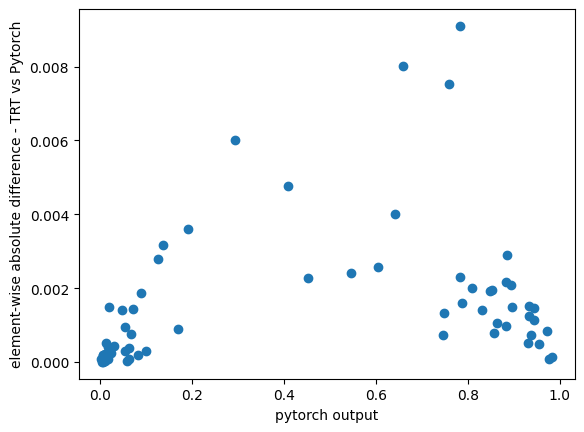

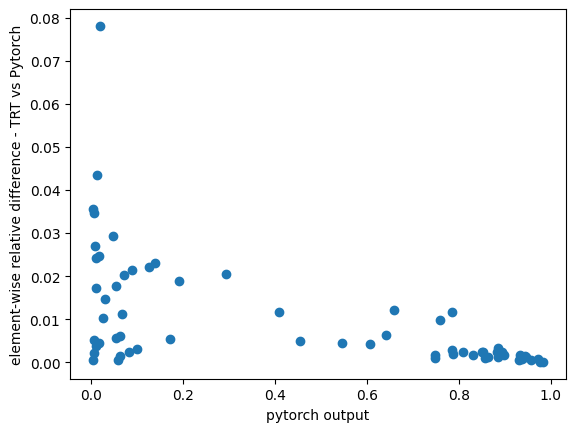

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(pytorch_output, all_abs_diffs)
plt.xlabel('pytorch output')
plt.ylabel('element-wise absolute difference - TRT vs Pytorch')

plt.figure()
plt.scatter(pytorch_output, all_rel_diffs)
plt.xlabel('pytorch output')
plt.ylabel('element-wise relative difference - TRT vs Pytorch')

plt.show()
